In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen import get_simu_data
from demo_settings import simu_settings

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [24]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras

def _add_res(res, key):
    all_res["Len"].append(res[key][-1])
    all_res["ITE"].append(res[key][0][0])
    all_res["CATE"].append(res[key][0][1])
    all_res["method"].append(key)
    for ky, v in cur_paras.items():
        all_res[ky].append(v)

res_dir = RES_ROOT/"demodp0_ablation_setting3_d10_n3000/"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
all_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDPM")
    _add_res(res, key="DDPM_sel")
    _add_res(res, key="CQR")
all_res_df = pd.DataFrame(all_res);

res_dir = RES_ROOT/"demodp0new_ablation_setting3_d10_n3000/"
all_fils = list(res_dir.glob("*n_T-*.pkl"));
all_res = ddict(list)
for fil in all_fils:
    cur_paras = fil_name2paras(fil.stem);
    res = load_pkl(fil, verbose=False);
    
    _add_res(res, key="DDPM")
    _add_res(res, key="DDPM_sel")
    _add_res(res, key="CQR")
all_res_df1 = pd.DataFrame(all_res);
#all_res_df["drop_prob"] = 0
all_res_df = pd.concat([all_res_df1, all_res_df]);

In [13]:
res_df = all_res_df.groupby(["n_infeat", "upblk", 
                             "downblk", "weight_decay", 
                             "lr", "n_T",   "method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])
#res_df.to_html("all_res.html");
#res_df

In [28]:
res_df = all_res_df.groupby(["n_T", "method"])[["Len", "ITE"]].agg(["mean", "median", "std", "count"])
res_df

Len                                 ITE                   \
                    mean    median       std count      mean median       std   
n_T   method                                                                    
100.0 CQR       4.189088  4.194457  0.218936   543  0.949396  0.950  0.013789   
      DDPM      5.493471  5.196494  1.198700   543  0.935260  0.936  0.016613   
      DDPM_sel  5.153713  4.872710  1.354134   543  0.937667  0.938  0.014885   
400.0 CQR       4.191281  4.194457  0.219963   560  0.949539  0.950  0.013668   
      DDPM      7.874605  6.088382  5.846223   560  0.935198  0.936  0.017924   
      DDPM_sel  6.461067  5.169323  4.210303   560  0.939375  0.941  0.016540   

                      
               count  
n_T   method          
100.0 CQR        543  
      DDPM       543  
      DDPM_sel   543  
400.0 CQR        560  
      DDPM       560  
      DDPM_sel   560

# Get result under best combone

In [26]:
def get_res_at_com(all_res_df, com):
    kpidx = np.ones(all_res_df.shape[0], dtype=bool)
    for ky, v in com.items():
        if ky == "method":
            continue
        kpidx = np.bitwise_and(kpidx,all_res_df[ky] == v)
    return all_res_df[kpidx]

In [27]:
best_com = dict()
best_com["n_infeat"] = 128
best_com["upblk"] = 3
best_com["downblk"] = 3
best_com["weight_decay"] = 0.01
best_com["lr"] = 0.01
best_com["n_T"] = 100
best_com["method"] = "DDPM_sel"

In [22]:
res_df = get_res_at_com(all_res_df, best_com);
res_df = res_df[res_df["method"].isin(["CQR", best_com['method']])]
res_df.head()

,Len,ITE,CATE,method,lr,n_infeat,n_T,weight_decay,upblk,downblk,rep
19,6.524714,0.923,0.998,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,32
20,5.465805,0.944,0.998,CQR,0.01,128.0,100.0,0.01,3.0,3.0,32
25,9.175587,0.957,0.981,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,0
26,5.459108,0.934,1.000,CQR,0.01,128.0,100.0,0.01,3.0,3.0,0
34,9.436742,0.958,0.980,DDPM_sel,0.01,128.0,100.0,0.01,3.0,3.0,38


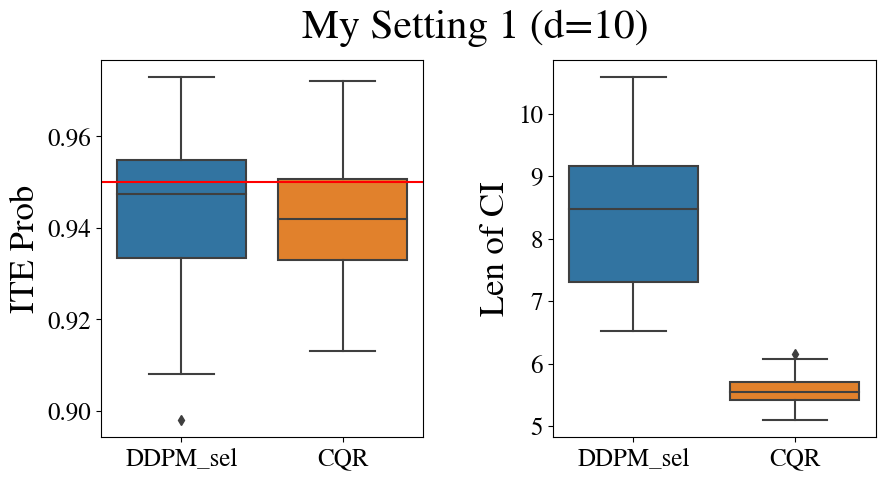

In [23]:
plt.suptitle(f"My Setting 1 (d=10)", fontsize=30)
plt.subplot(121)
sns.boxplot(data=res_df, y="ITE", x="method")
plt.axhline(y=0.95, color="red");
plt.xlabel("")
plt.ylabel("ITE Prob")
plt.subplot(122)
sns.boxplot(data=res_df, y="Len", x="method")
plt.xlabel("")
plt.ylabel("Len of CI");